In [185]:
using JLD2, LinearAlgebra, PyPlot, Tullio, Statistics, PottsGauge, DelimitedFiles

In [186]:
include("../src/dca_score.jl")
include("../src/utils.jl")
;

In [187]:
tt = ["A", "C", "F", "I", "L", "M", "V", "W", "Y", "P", "H", "K", "R", "D", "E", "N", "Q", "S", "T", "G"];

In [195]:
function int_matr(A; tt = tt, titolo = false, nametitle = "Interaction Matrix")
    matshow(A)
    xticks(0:19,tt)
    yticks(0:19,tt)
    tick_params(axis="both", which="both", bottom=false, top=false)
    if titolo == true
        title(nametitle)
    end        
    colorbar()
end

function zerosumgaug(m; mj = false)
    E_col = mean(m, dims = 2)
    E_row = mean(m, dims = 1)
    E_tot = mean(m)
    if mj == true
        res = -m .+ E_col .+ E_row .- E_tot;
    else
        res = m .- E_col .- E_row .+ E_tot
    end
    return res
end

function eigen_an(m, n_eig; tit = " ciao")  #the matrix should already be in the proper form
    l, vv = eigen(m)
    scatter(1:length(l), l);
    ord = sortperm(abs.(l), rev=true)
    ll = l[sortperm(abs.(l), rev=true)]
    scatter(ord[1:n_eig], ll[1:n_eig]);
    print("Explained Var : ")
    println(round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(l))), digits = 2))
    int_matr(m, titolo = true, nametitle = "Total " * tit)
    for i in 1:n_eig
        tit1 = "Proj l = $(round(ll[i], digits=2)) "
        int_matr(vv[:,ord[i]]' .* vv[:,ord[i]], titolo = true, nametitle = tit1 * tit); 
    end
end

function compute_mat_mf(m)
    Vm = m.V[order_Martin,:]
    Nf = length(m.Ks)
    H = size(m.V,2)
    JJ = []
    for f in 1:Nf
        @tullio J[i,j,a,b] := m.Ks[f][i,j,h]*Vm[a,h]*Vm[b,h]*(j!=i)
        push!(JJ, J)
    end
    J0 = [mean(mean(JJ[f], dims = 3), dims=4) for f in 1:Nf]  
    JJ_zs = [JJ[f] .- mean(JJ[f], dims = 3) .- mean(JJ[f], dims = 4) .+ J0[f] for f in 1:Nf]
    println([sum(dropdims(dropdims(mean(mean(JJ_zs[f], dims = 1), dims=2),
                    dims=1),dims=1), dims=1) for f in 1:Nf])
    e_all = mean([dropdims(dropdims(mean(mean(JJ_zs[f], dims = 1), dims=2),
                    dims=1),dims=1) for f in 1:Nf])
    return e_all
end

function compute_mat_sf(m)
    Vm = m.V[order_Martin,:]
    H = size(m.V,2)
    @tullio J[i,j,a,b] := m.K[i,j,h]*Vm[a,h]*Vm[b,h]*(j!=i)
    J0 = mean(mean(J, dims = 3), dims=4)  
    JJ_zs = J .- mean(J, dims = 3) .- mean(J, dims = 4) .+ J0 
    e_all = dropdims(dropdims(mean(mean(JJ_zs, dims = 1), dims=2),
                    dims=1),dims=1)
    println(sum(e_all, dims=1))
    println(sum(e_all, dims=2))
    return e_all
end

function showVmat_mf(m, n_eig; tit = " ")
    Nf = length(m.Ks)
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    llh = mean([@tullio lam[h] := m1.Ks[f][i,j,h]*(j!=i) for f in 1:Nf]);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
end

function showVmat_sf(m, n_eig; tit = " ")
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    VV0 = mean(mean(VV,dims = 1), dims=2)
    VVV = VV .- mean(VV, dims=1) .- mean(VV, dims=2) .- VV0
    println(sum(VVV[:,:,1], dims=1))
    println(sum(VVV[:,:,1], dims=2))
    @tullio llh[h] := m1.K[i,j,h]*(j!=i);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VVV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
    return VV
end


  


showVmat_sf (generic function with 1 method)

In [ ]:
@load "../../InteractionMatrix.jld2"

## Miyazawa Jernigan

In [ ]:
EE = zerosumgaug(E1_martin, mj = true)
n_eig = 4
eigen_an(EE, n_eig, tit = "MJ")

## Multi family with ort

In [ ]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
structfiles = ["../../DataAttentionDCA/data/PF00014/PF00014_struct.dat", 
    "../../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat",
    "../../DataAttentionDCA/data/PF00677/Atomic_distances_PF00677.dat",
    "../../DataAttentionDCA/data/PF00076/PF00076_struct.dat",
    "../../DataAttentionDCA/data/PF00035/Atomic_distances_PF00035.dat"]
aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "mf with ort filtered")
;

In [ ]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
aa = compute_mat_mf(m1)
eigen_an(aa, n_eig, tit = "mf with ort")
;

In [ ]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
showVmat_mf(m1, n_eig, tit = "mf with ort")
;

## Single family with ort

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf with ort filtered")
;

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ;n_eig = 4; 
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf with ort")
;

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 4; 
showVmat_sf(m1, n_eig, tit = "sf with ort");

In [ ]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered")
;

## Single family no ort

Float32[1.8626451f-9 -4.656613f-10 1.8626451f-9 2.3283064f-10 3.7252903f-9 0.0 -1.8626451f-9 4.656613f-10 9.313226f-10 2.7939677f-9 8.731149f-11 -1.1059456f-9 4.8894435f-9 0.0 -9.895302f-10 3.0267984f-9 9.313226f-10 2.3283064f-10 -1.1641532f-9 1.8626451f-9]
Float32[2.7939677f-9; 2.7939677f-9; 3.7252903f-9; -1.3969839f-9; 9.313226f-10; 6.4028427f-10; -2.3283064f-10; -6.9849193f-10; 1.9790605f-9; 9.313226f-10; -3.4924597f-10; -1.6880222f-9; 3.3760443f-9; 4.656613f-10; 1.5133992f-9; -6.9849193f-10; 0.0; -6.9849193f-10; -3.7252903f-9; 1.8626451f-9;;]
Explained Var : Float32[0.23, 0.4, 0.51, 0.61]


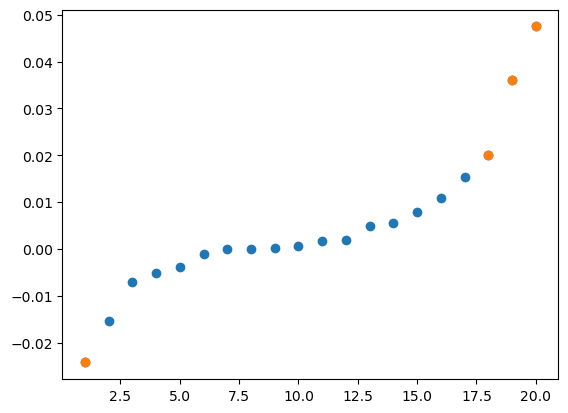

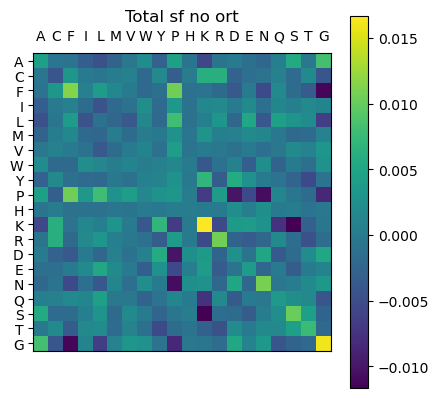

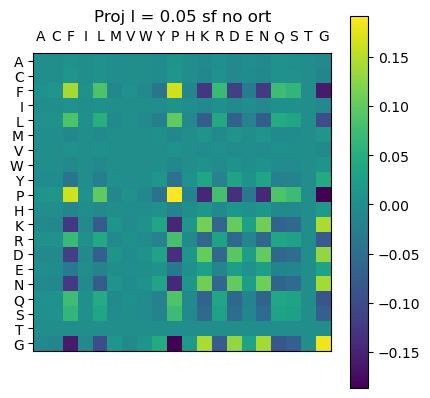

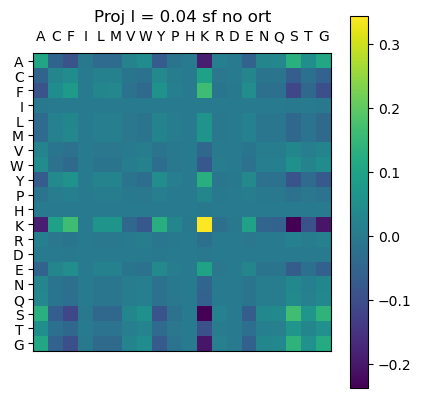

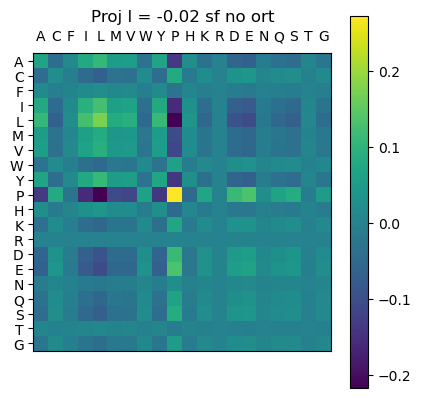

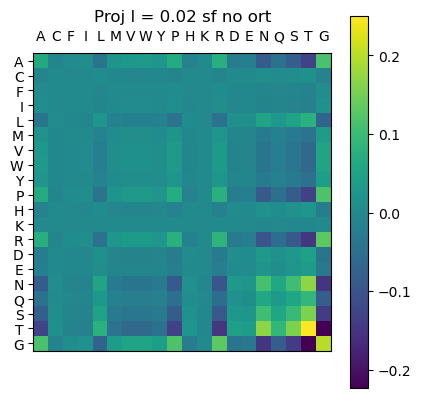

In [208]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf no ort")
;


Float32[-0.00035775732 -0.00035767257 -0.0003577564 -0.0003577564 -0.00035775919 -0.0003577657 -0.00035775919 -0.00035775942 -0.0003577508 -0.00035774894 -0.0003577564 -0.00035774335 -0.00035775453 -0.00035776012 -0.00035776943 -0.00035775825 -0.00035774522 -0.00035776198 -0.00035778433 -0.00035775884 -0.00035778806]
Float32[-0.0003577536; -0.00035767257; -0.0003577564; -0.0003577564; -0.00035775919; -0.0003577657; -0.00035775919; -0.00035775942; -0.00035775453; -0.00035775267; -0.0003577564; -0.00035774335; -0.0003577508; -0.00035775825; -0.00035776943; -0.00035775825; -0.00035774522; -0.0003577564; -0.00035778433; -0.00035775884; -0.00035778806;;]
Explained variance : Float32[0.16, 0.25, 0.34, 0.43]


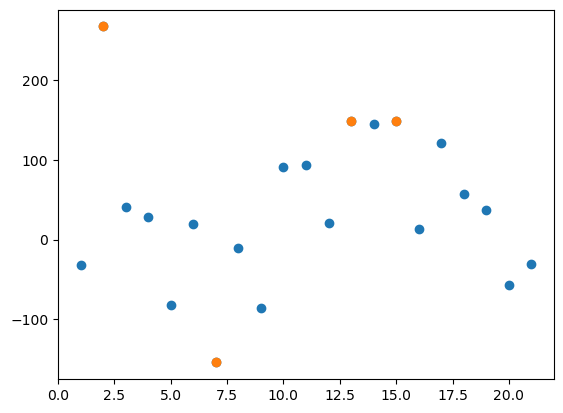

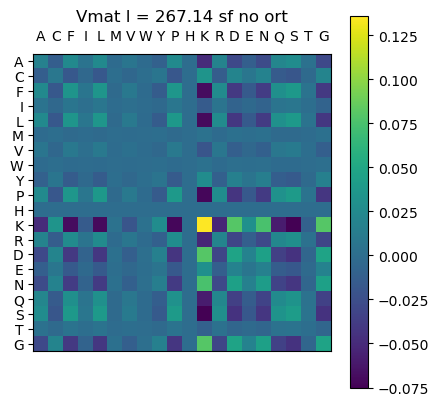

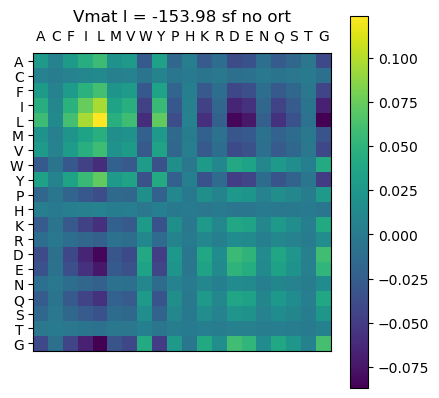

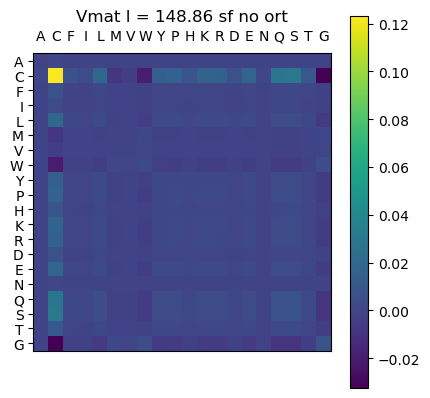

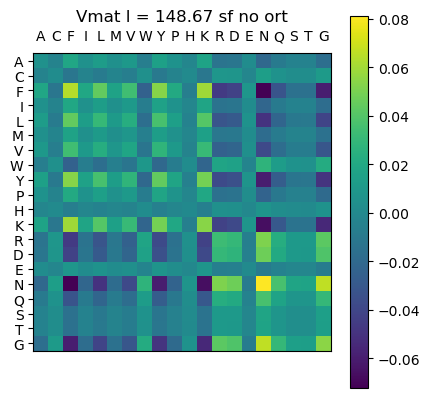

In [214]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4; 
VV1 = showVmat_sf(m1, n_eig, tit = "sf no ort");

Explained Var : [0.23, 0.43, 0.54, 0.62]


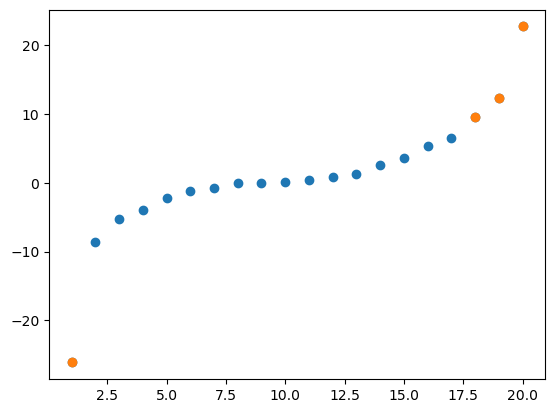

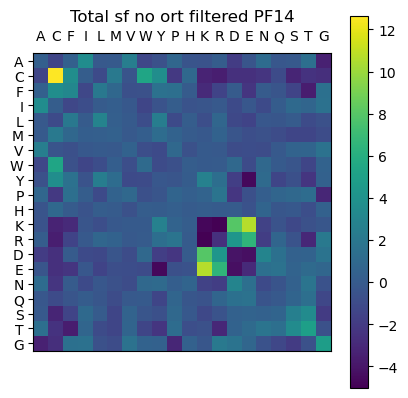

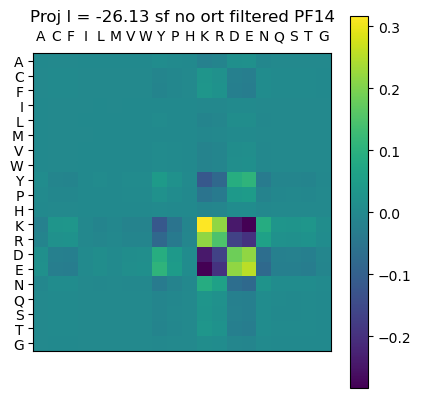

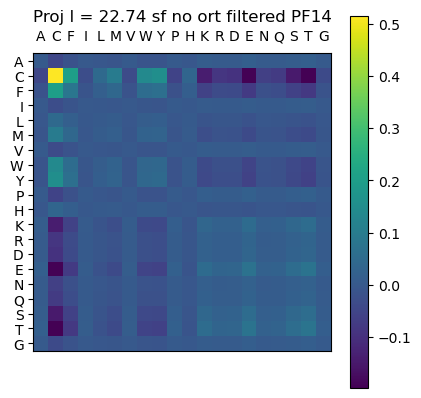

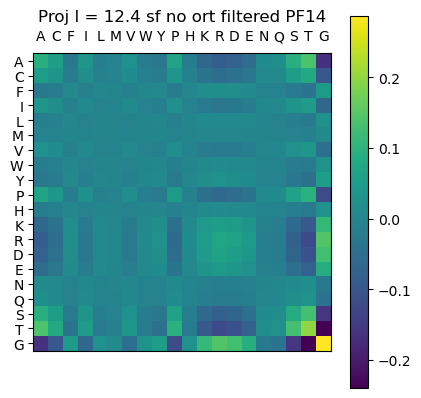

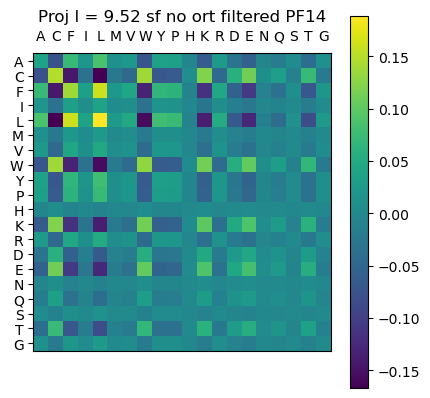

In [215]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered PF14")
;

Explained Var : [0.26, 0.49, 0.63, 0.73]


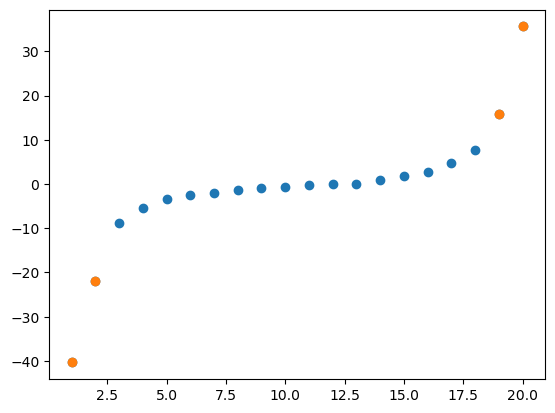

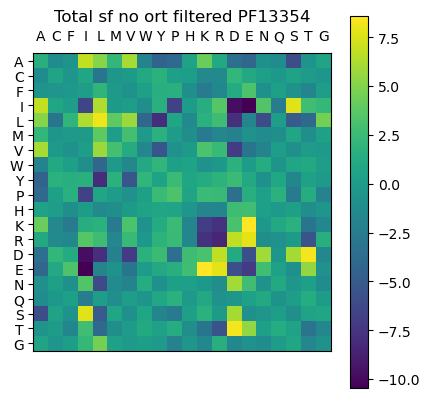

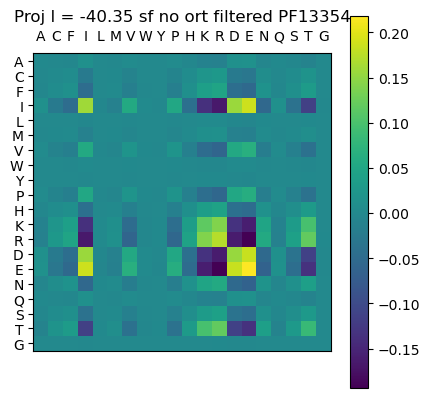

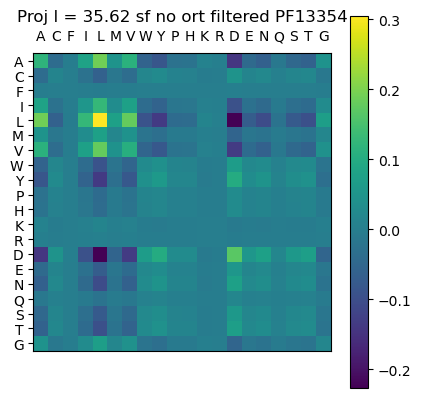

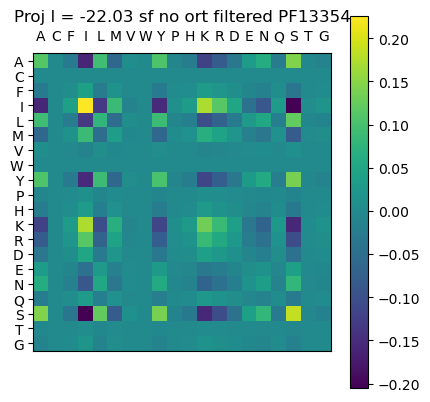

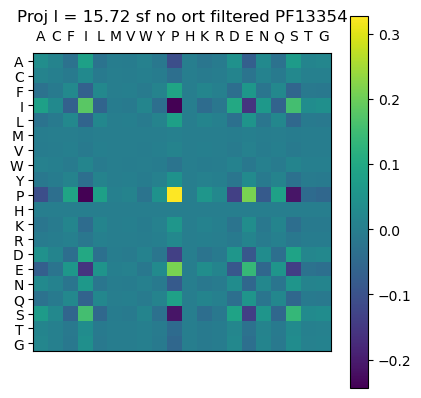

In [216]:
@load "../../DataAttentionDCA/data/PF13354/ortfalse_parsH21η0.5λ0.001T150.jld2"
m1 = m ; n_eig = 4;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF13354/PF13354_struct.dat",
    ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "sf no ort filtered PF13354")
;

## Multi family no ort

(101,)
(110,)
(215,)
(133,)
(182,)
Explained Var : [0.35, 0.47, 0.57, 0.64]


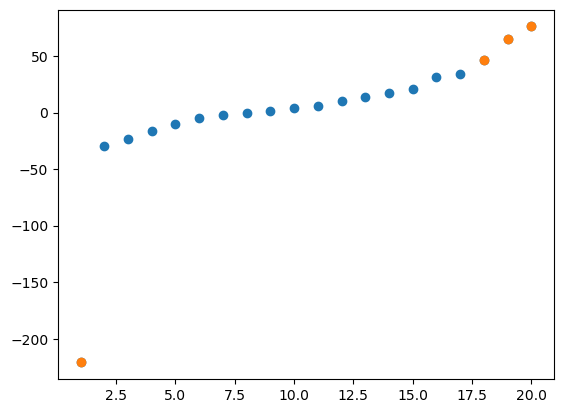

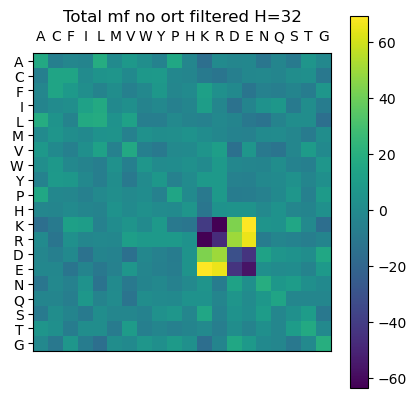

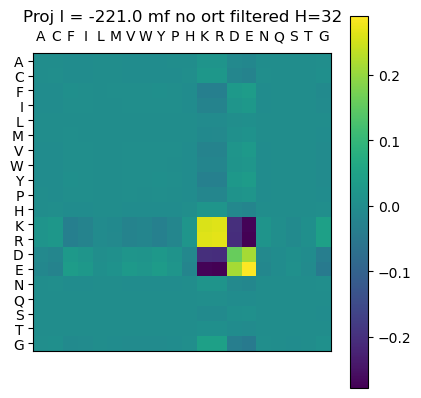

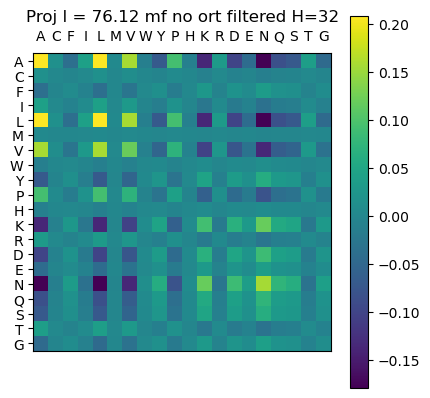

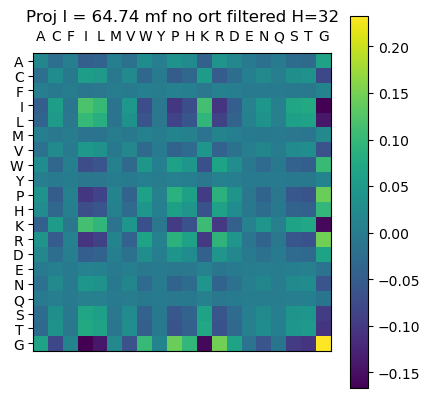

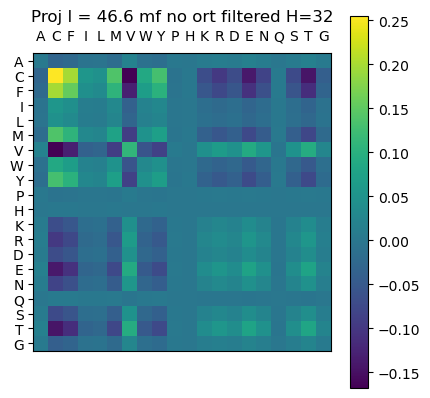

In [217]:
@load "../../multi_fam/H32η0.5λ0.001/mf_pars14_H32η0.5λ0.001T60.jld2"
m1 = m ; n_eig = 4;
structfiles = ["../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    "../../DataAttentionDCA/data/PF00035/Atomic_distances_PF00035.dat",
    "../../DataAttentionDCA/data/PF00076/PF00076_struct.dat",
    "../../DataAttentionDCA/data/PF00677/Atomic_distances_PF00677.dat",
    "../../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat"]
    
aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "mf no ort filtered H=32")
;

Explained variance : Float32[0.12, 0.22, 0.3, 0.36, 0.43]


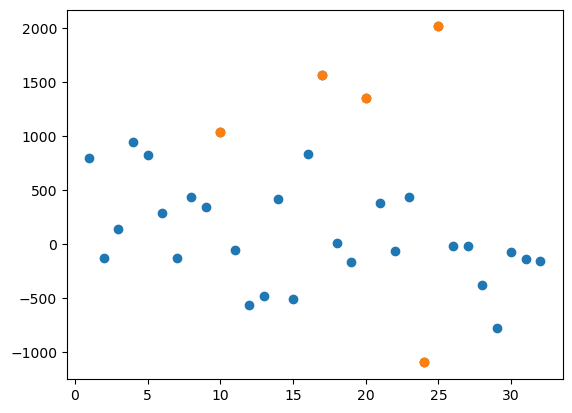

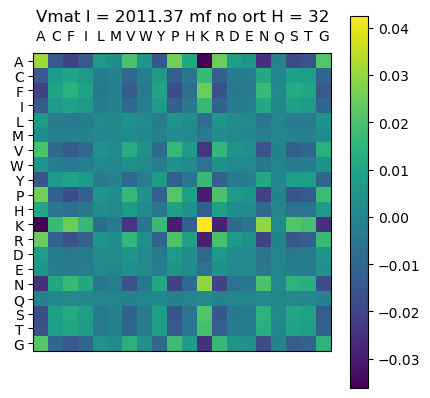

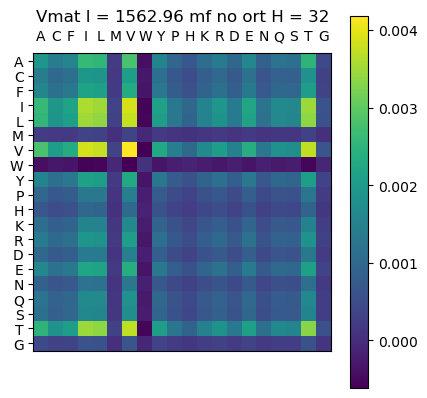

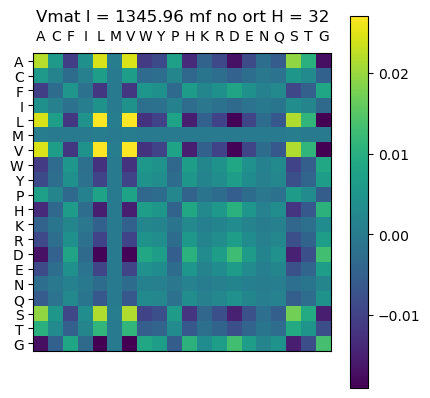

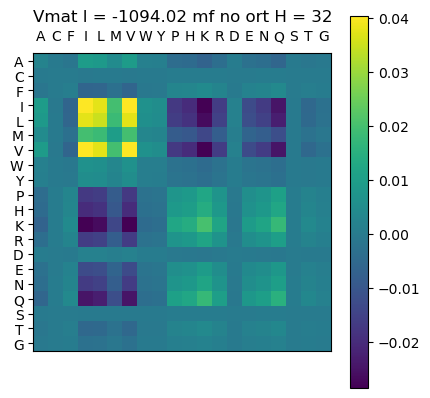

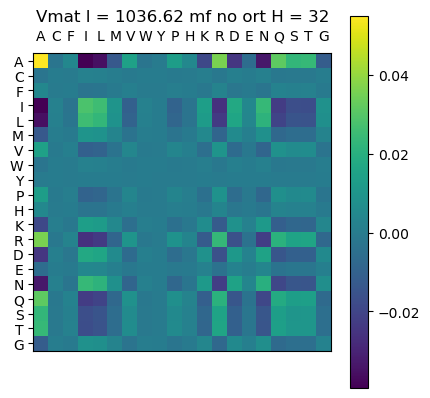

In [222]:
@load "../../multi_fam/H32η0.5λ0.001/mf_pars14_H32η0.5λ0.001T60.jld2"
m1 = m ; n_eig = 5;
showVmat_mf(m1, n_eig, tit = "mf no ort H = 32")
;

(92,)
(171,)
(114,)
(178,)
(93,)
Explained Var : [0.38, 0.5, 0.6, 0.69]


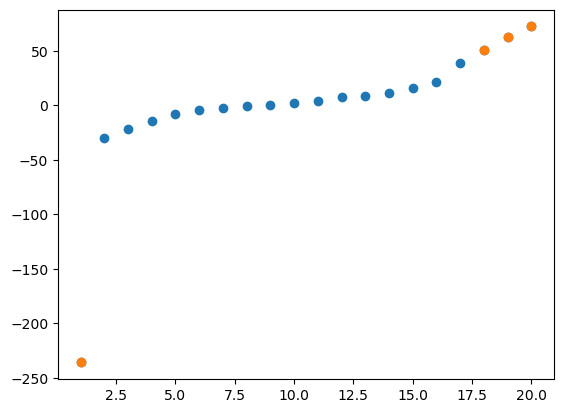

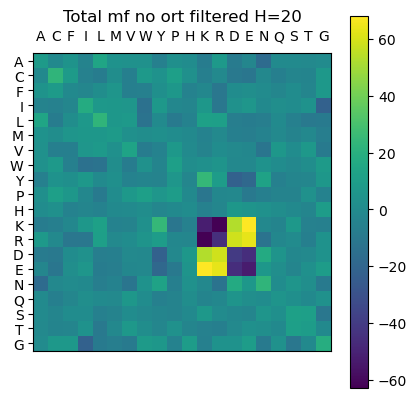

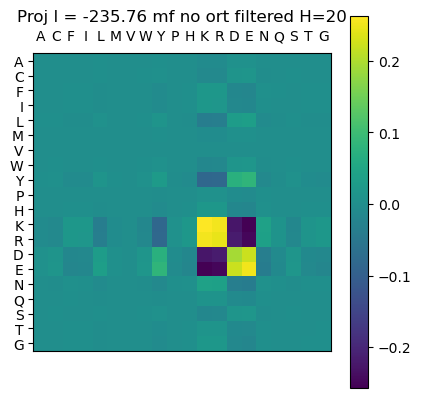

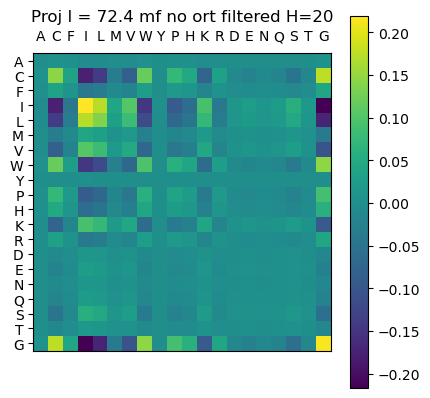

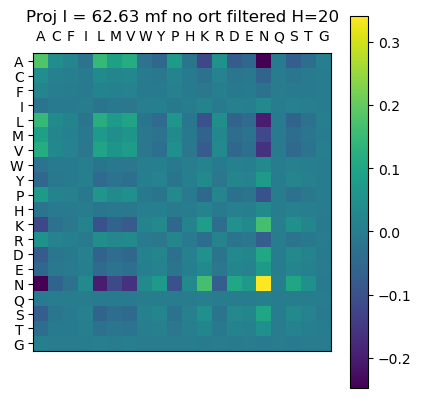

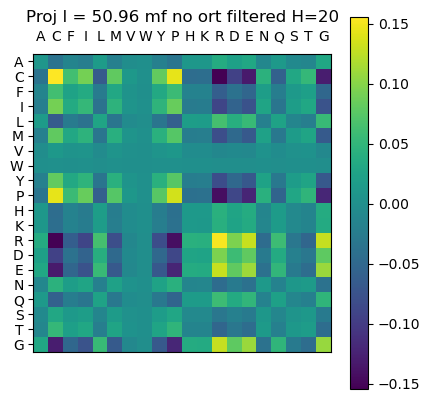

In [218]:
@load "../../multi_fam/H20η0.5λ0.001/parsH20.jld2"
m1 = m ; n_eig = 4;
structfiles = ["../../DataAttentionDCA/data/PF00014/PF00014_struct.dat", 
    "../../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat",
    "../../DataAttentionDCA/data/PF00677/Atomic_distances_PF00677.dat",
    "../../DataAttentionDCA/data/PF00076/PF00076_struct.dat",
    "../../DataAttentionDCA/data/PF00035/Atomic_distances_PF00035.dat"]
aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.8)
eigen_an(aa, n_eig, tit = "mf no ort filtered H=20")
;

Explained variance : Float32[0.26, 0.39, 0.46, 0.53, 0.59]


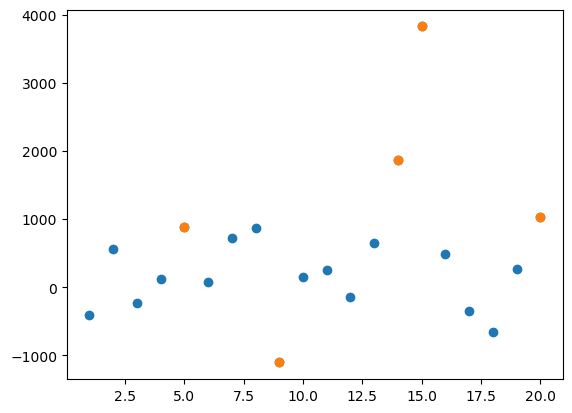

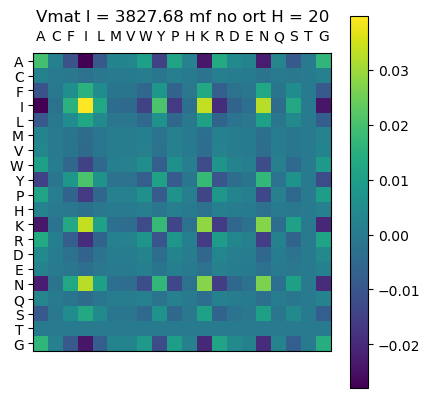

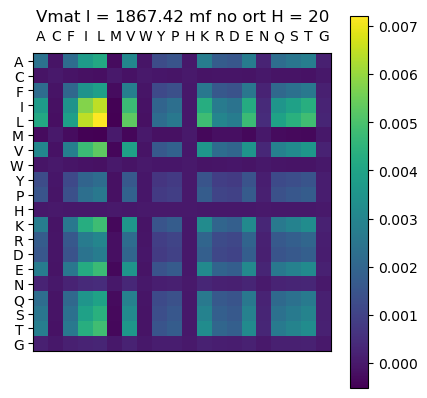

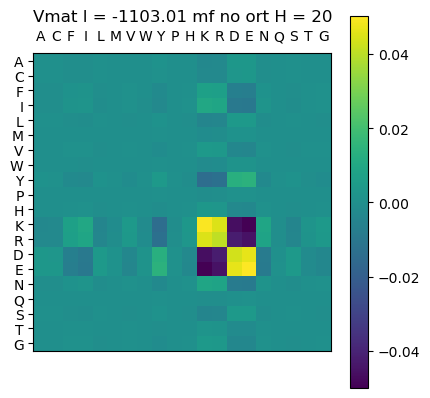

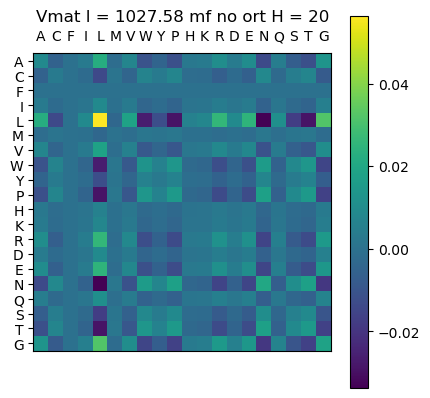

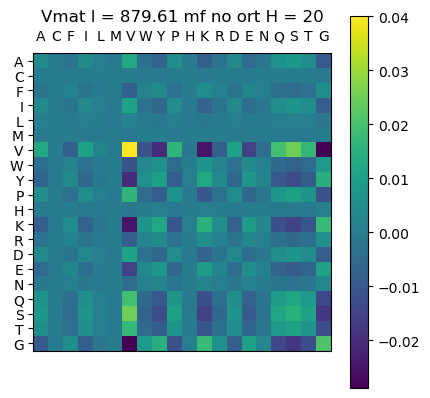

In [223]:
@load "../../multi_fam/H20η0.5λ0.001/parsH20.jld2"
m1 = m ; n_eig = 5;
showVmat_mf(m1, n_eig, tit = "mf no ort H = 20")
;